# Generative Adversarial Networks Application on MNIST data

Core Components:

  *  Import Libraries
  *  Load and Preprocess MNIST
  *  Define Generator Architecture
  *  Define Discriminator Architecture
  *  Instantiate Models and Initialize Weights
  *  Loss Function and Optimizers
  *  Training Loop
  *  Generate Samples

References:


  1.  stackoverflow.com/questions/72767476/how-to-increase-a-size-of-image-in-dcgan-in-python
  2.  github.com/2asyhard/Generative-Adversarial-Networks
  3.  github.com/KavinRV/GANs
  4.  github.com/sarckk/ml-models
  5.  github.com/22385wjy/fusing_MRandPETimages
  6.  github.com/AquibPy/Pytorch


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
# Hyperparameters
batch_size = 96
num_epochs = 20
learning_rate = 0.00025
latent_dim = 128  # Size of noise vector

# Data preparation
transform = transforms.Compose([
    transforms.Resize((64,64),antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [63]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)  # Normal distribution (mean=0, std=0.02)



In [64]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            # Input: Noise vector
            self.deconv_block(latent_dim, 512, 4, 1, 0),  # Start from a smaller image
            self.deconv_block(512, 256, 4, 2, 1),
            self.deconv_block(256, 128, 4, 2, 1),
            self.deconv_block(128, 64, 4, 2, 1),
            # Output:
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def deconv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.model(x)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input:
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            self.conv_block(64, 128, 4, 2, 1),
            self.conv_block(128, 256, 4, 2, 1),
            self.conv_block(256, 512, 4, 2, 1),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

# Initialize generator, discriminator, and apply weight initialization
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
initialize_weights(generator)
initialize_weights(discriminator)

In [65]:
# Loss and optimizers
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss - suitable for GANs
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [66]:
# TensorBoard setup for visualization
writer = SummaryWriter("runs/dcgan_mnist")

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Train discriminator with real images
        discriminator.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        output = discriminator(images).view(-1)
        loss_d_real = criterion(output, real_labels.squeeze(1))
        loss_d_real.backward()

        # Train discriminator with fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        output = discriminator(fake_images.detach()).view(-1)  # detach to avoid backprop through G
        loss_d_fake = criterion(output, fake_labels.squeeze(1))
        loss_d_fake.backward()
        loss_d = loss_d_real + loss_d_fake
        optimizer_d.step()

        # Train generator
        generator.zero_grad()
        output = discriminator(fake_images).view(-1)
        loss_g = criterion(output, real_labels.squeeze(1))  # Aim to fool the discriminator
        loss_g.backward()
        optimizer_g.step()

        # Logging and visualization
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}")

            with torch.no_grad():
                fake_images = generator(noise)
                img_grid = torchvision.utils.make_grid(fake_images, normalize=True)
                writer.add_image('Generated Images', img_grid, global_step=epoch * len(dataloader) + i)

# Close TensorBoard writer when done
writer.close()

Epoch [0/20] Batch 0/625                   Loss D: 1.3841, Loss G: 0.8051
Epoch [0/20] Batch 100/625                   Loss D: 0.0262, Loss G: 4.3209
Epoch [0/20] Batch 200/625                   Loss D: 0.0088, Loss G: 5.5130
Epoch [0/20] Batch 300/625                   Loss D: 0.0058, Loss G: 6.0605
Epoch [0/20] Batch 400/625                   Loss D: 0.4745, Loss G: 3.0067
Epoch [0/20] Batch 500/625                   Loss D: 0.2126, Loss G: 3.0450
Epoch [0/20] Batch 600/625                   Loss D: 0.9645, Loss G: 0.3474
Epoch [1/20] Batch 0/625                   Loss D: 1.2746, Loss G: 0.9268
Epoch [1/20] Batch 100/625                   Loss D: 0.3642, Loss G: 2.0783
Epoch [1/20] Batch 200/625                   Loss D: 0.4695, Loss G: 2.4484
Epoch [1/20] Batch 300/625                   Loss D: 0.6366, Loss G: 1.8954
Epoch [1/20] Batch 400/625                   Loss D: 0.9605, Loss G: 1.0799
Epoch [1/20] Batch 500/625                   Loss D: 0.7035, Loss G: 2.1355
Epoch [1/20] Bat

# Visualize the Deep Fakes

In [67]:
with torch.no_grad():
    noise = torch.randn(64, latent_dim, 1, 1, device=device)
    generated_images = generator(noise)
    img_grid = torchvision.utils.make_grid(generated_images, normalize=True)

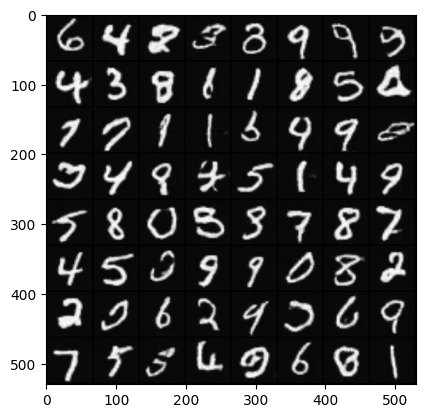

In [68]:
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
plt.show()